In [1]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split  # not used here, split based on provider
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# for integer encoding using sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve  


from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

from sklearn.metrics import auc,plot_precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

from sklearn.metrics import roc_curve,auc,RocCurveDisplay

# Set seed for reproducibility
seed1, seed2, seed3=101, 67, 42

## Load and Merge Data

In [3]:
# load the data from csv to pandas dataframe
Healthcare_Provider_raw = pd.read_csv("data/Train-1542865627584.csv")
Healthcare_Beneficiary_raw = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")
Healthcare_Inpatient_raw = pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")
Healthcare_Outpatient_raw = pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")

In [4]:
# Assign inpatient data as 1, outpatient data as 0
Healthcare_Inpatient_raw['In_Out']=1
Healthcare_Outpatient_raw['In_Out']=0

# union/concat the inpatient and outpatient data
concat_df=pd.concat([Healthcare_Inpatient_raw,Healthcare_Outpatient_raw],axis=0)

# left join tables
merge_bene_df=concat_df.merge(Healthcare_Beneficiary_raw, on='BeneID', how='left')
merge_provider_df=merge_bene_df.merge(Healthcare_Provider_raw, on = 'Provider', how ='left')
merge_provider_df.drop_duplicates(inplace=True)

# remove columns with all null values
merge_provider_df.dropna(axis=1, how='all',inplace=True)

# drop ClaimID since it behaves as index
merge_provider_df.drop('ClaimID',axis=1, inplace=True)

# check the final merged dataframe
merge_provider_df

,BeneID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,...,2,1,2,2,2,21260,2136,120,100,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558207,BENE159198,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558208,BENE159198,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No
558209,BENE159198,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,...,1,2,2,1,2,0,0,5470,1870,No


## Basic Transformation

In [5]:
# get a copy of the merged data, prepare change all to numerical
df_num=merge_provider_df.copy(deep=True)

In [6]:
# seperate columns into target, num, datetime, categorical
target=['PotentialFraud']
colnames=df_num.columns.to_list()

datetime_col_list=['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','DOB','DOD']

diagnosis_code_columns = [x for x in list(df_num.columns) if 'ClmDiag' in x]
procedure_code_columns = [x for x in list(df_num.columns) if 'ClmProc' in x]
physican_columns = [x for x in list(df_num.columns) if 'Physician' in x]
Chronic_columns = [x for x in list(df_num.columns) if 'ChronicCond' in x]
Amt_columns=[x for x in list(df_num.columns) if 'Amt' in x]
NoOfMonths_columns=[x for x in list(df_num.columns) if 'NoOfMonth' in x]

In [7]:
cat_col_list=list(set(colnames)-set(Amt_columns)-set(NoOfMonths_columns)-set(target)-set(datetime_col_list)-{'In_Out'})
cat_col_list.sort()
cat_col_list

['AttendingPhysician',
 'BeneID',
 'ChronicCond_Alzheimer',
 'ChronicCond_Cancer',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_Heartfailure',
 'ChronicCond_IschemicHeart',
 'ChronicCond_KidneyDisease',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke',
 'ClmAdmitDiagnosisCode',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_10',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'County',
 'DiagnosisGroupCode',
 'Gender',
 'OperatingPhysician',
 'OtherPhysician',
 'Provider',
 'Race',
 'RenalDiseaseIndicator',
 'State']

### label 1 as fraud, 0 as genuine

In [8]:
# transform target to binary code

df_num['PotentialFraud']=df_num['PotentialFraud'].map(lambda x:1 if (x=='Yes' or x==1) else 0)

df_num.head()

# change date column datatype to datetime

for datetime_col_name in datetime_col_list:
    df_num[datetime_col_name]=pd.to_datetime(df_num[datetime_col_name])

### DateTime Columns Transform

In [9]:
#calculate age and determine if a person is deceased. If the person is still alive, 
#use '2009-12-01' as the time we calculate age

from datetime import date, datetime
def calulateAge(dob, dod, calulationDate):
    born = dob
    if not pd.isna(dod):
        calulationDate = dod
    else:
        calulationDate = datetime.strptime(calulationDate, "%Y-%m-%d").date()
    return calulationDate.year - born.year - ((calulationDate.month, calulationDate.day) < (born.month, born.day))    


df_num['Deceased'] = df_num['DOD'].apply(lambda x : 0 if pd.isna(x) else 1) 
df_num['Age'] = df_num.apply(lambda x: calulateAge(dob = x['DOB'], dod = x['DOD'], calulationDate = '2009-12-01'), axis = 1)

In [10]:
# calculte claimPeriod and HospitalizedDays
# df_num = merge_provider_df.copy(deep=True)
df_num['ClaimPeriod'] = (pd.to_datetime(df_num.ClaimEndDt) - pd.to_datetime(df_num.ClaimStartDt)).dt.days + 1
df_num['HospitalizedDays'] = (pd.to_datetime(df_num.DischargeDt) - pd.to_datetime(df_num.AdmissionDt)).dt.days + 1
# make hospitallized day 0 for outpatient
df_num['HospitalizedDays'] = df_num['HospitalizedDays'].apply(lambda x : 0 if pd.isna(x) else x )

### Add count of diagonosis, procedure, chronic condition and physican as new columns

## Transform Binary Categorical Columns

In [11]:
cat_nunique=df_num[cat_col_list].nunique()
cat_binary_list=list(cat_nunique[cat_nunique==2].index)
cat_binary_list

['ChronicCond_Alzheimer',
 'ChronicCond_Cancer',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_Heartfailure',
 'ChronicCond_IschemicHeart',
 'ChronicCond_KidneyDisease',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke',
 'Gender',
 'RenalDiseaseIndicator']

In [12]:
# Dummy Encode the binary columns in the df_num

one_hot_binary_df=pd.get_dummies(df_num[cat_binary_list], prefix={i for i in cat_binary_list}, columns=cat_binary_list, drop_first=True)
# one_hot_binary_df.drop(cat_binary_list,axis=1,inplace=True)
one_hot_binary_df.head()

,ChronicCond_Cancer_2,ChronicCond_Depression_2,ChronicCond_Heartfailure_2,RenalDiseaseIndicator_2,ChronicCond_IschemicHeart_2,ChronicCond_KidneyDisease_2,ChronicCond_stroke_2,ChronicCond_Osteoporasis_2,Gender_2,ChronicCond_Alzheimer_2,ChronicCond_ObstrPulmonary_2,ChronicCond_Diabetes_2,ChronicCond_rheumatoidarthritis_Y
0,0,1,0,0,1,0,0,1,1,0,0,0,0
1,0,1,0,0,1,0,0,1,1,0,0,0,0
2,0,1,0,0,1,0,0,1,1,0,0,0,0
3,1,1,0,0,0,1,0,1,1,0,0,1,0
4,1,1,0,1,0,0,0,0,1,1,1,1,1


In [13]:
one_hot_binary_df.columns

Index(['ChronicCond_Cancer_2', 'ChronicCond_Depression_2',
       'ChronicCond_Heartfailure_2', 'RenalDiseaseIndicator_2',
       'ChronicCond_IschemicHeart_2', 'ChronicCond_KidneyDisease_2',
       'ChronicCond_stroke_2', 'ChronicCond_Osteoporasis_2', 'Gender_2',
       'ChronicCond_Alzheimer_2', 'ChronicCond_ObstrPulmonary_2',
       'ChronicCond_Diabetes_2', 'ChronicCond_rheumatoidarthritis_Y'],
      dtype='object')

## Dummy Transform (Categorical Columns)

In [14]:
cat_dummy_list=list(cat_nunique[cat_nunique!=2].index)
cat_dummy_list

['AttendingPhysician',
 'BeneID',
 'ClmAdmitDiagnosisCode',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_10',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'County',
 'DiagnosisGroupCode',
 'OperatingPhysician',
 'OtherPhysician',
 'Provider',
 'Race',
 'State']

In [21]:
cat_dummy_list.remove('Provider')

In [15]:
class OHE_Transformer(object):
    def __init__(self):
        self.dummy = {}
    
    def fit(self, X, y=None):
        ohe = OneHotEncoder(categories='auto', drop='if_binary',sparse=False, max_categories=15)
        ohe_df = pd.DataFrame(ohe.fit_transform(X[cat_dummy_list]))
        ohe_df.columns=ohe.get_feature_names_out(cat_dummy_list)
        self.columns=ohe_df.columns
        
    def transform(self,X,y=None):
        ohe = OneHotEncoder(categories='auto', drop='if_binary',sparse=False, max_categories=15)
        ohe_df = pd.DataFrame(ohe.fit_transform(X[cat_dummy_list]))
        ohe_df.columns=ohe.get_feature_names_out(cat_dummy_list)
        df=pd.DataFrame(columns=ohe_df.columns)
        common_col_list=list(set(self.columns).intersection(ohe_df.columns))
        df=pd.concat([df,ohe_df[common_col_list]],axis=0)
        return df.fillna(0)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
# ohe_xfmer=OHE_Transformer()
# ohe_xfmer.fit_transform(df_num)

In [16]:
col_names_all=list(df_num.columns)
col_names_all.remove('Provider')  # remove does not have a return value (inplace=True)
col_names_all.remove('PotentialFraud')  # remove does not have a return value (inplace=True)
col_names_all.insert(0,'Provider')
col_names_all.insert(0,'PotentialFraud')

df_num_reorder=df_num[col_names_all].copy(deep=True)
df_num_reorder=pd.concat([df_num_reorder,one_hot_binary_df],axis=1)
df_num_reorder.drop(datetime_col_list,axis=1, inplace=True)
df_num_reorder.drop(cat_binary_list,axis=1, inplace=True)

# df_num_reorder.fillna(-1,inplace=True)
df_num_reorder.head()

,PotentialFraud,Provider,BeneID,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,...,RenalDiseaseIndicator_2,ChronicCond_IschemicHeart_2,ChronicCond_KidneyDisease_2,ChronicCond_stroke_2,ChronicCond_Osteoporasis_2,Gender_2,ChronicCond_Alzheimer_2,ChronicCond_ObstrPulmonary_2,ChronicCond_Diabetes_2,ChronicCond_rheumatoidarthritis_Y
0,1,PRV55912,BENE11001,26000,PHY390922,NaN,NaN,7866,1068.0,201,...,0,1,0,0,1,1,0,0,0,0
1,0,PRV55907,BENE11001,5000,PHY318495,PHY318495,NaN,6186,1068.0,750,...,0,1,0,0,1,1,0,0,0,0
2,0,PRV56046,BENE11001,5000,PHY372395,NaN,PHY324689,29590,1068.0,883,...,0,1,0,0,1,1,0,0,0,0
3,0,PRV52405,BENE11011,5000,PHY369659,PHY392961,PHY349768,431,1068.0,067,...,0,0,1,0,1,1,0,0,1,0
4,0,PRV56614,BENE11014,10000,PHY379376,PHY398258,NaN,78321,1068.0,975,...,1,0,0,0,0,1,1,1,1,1


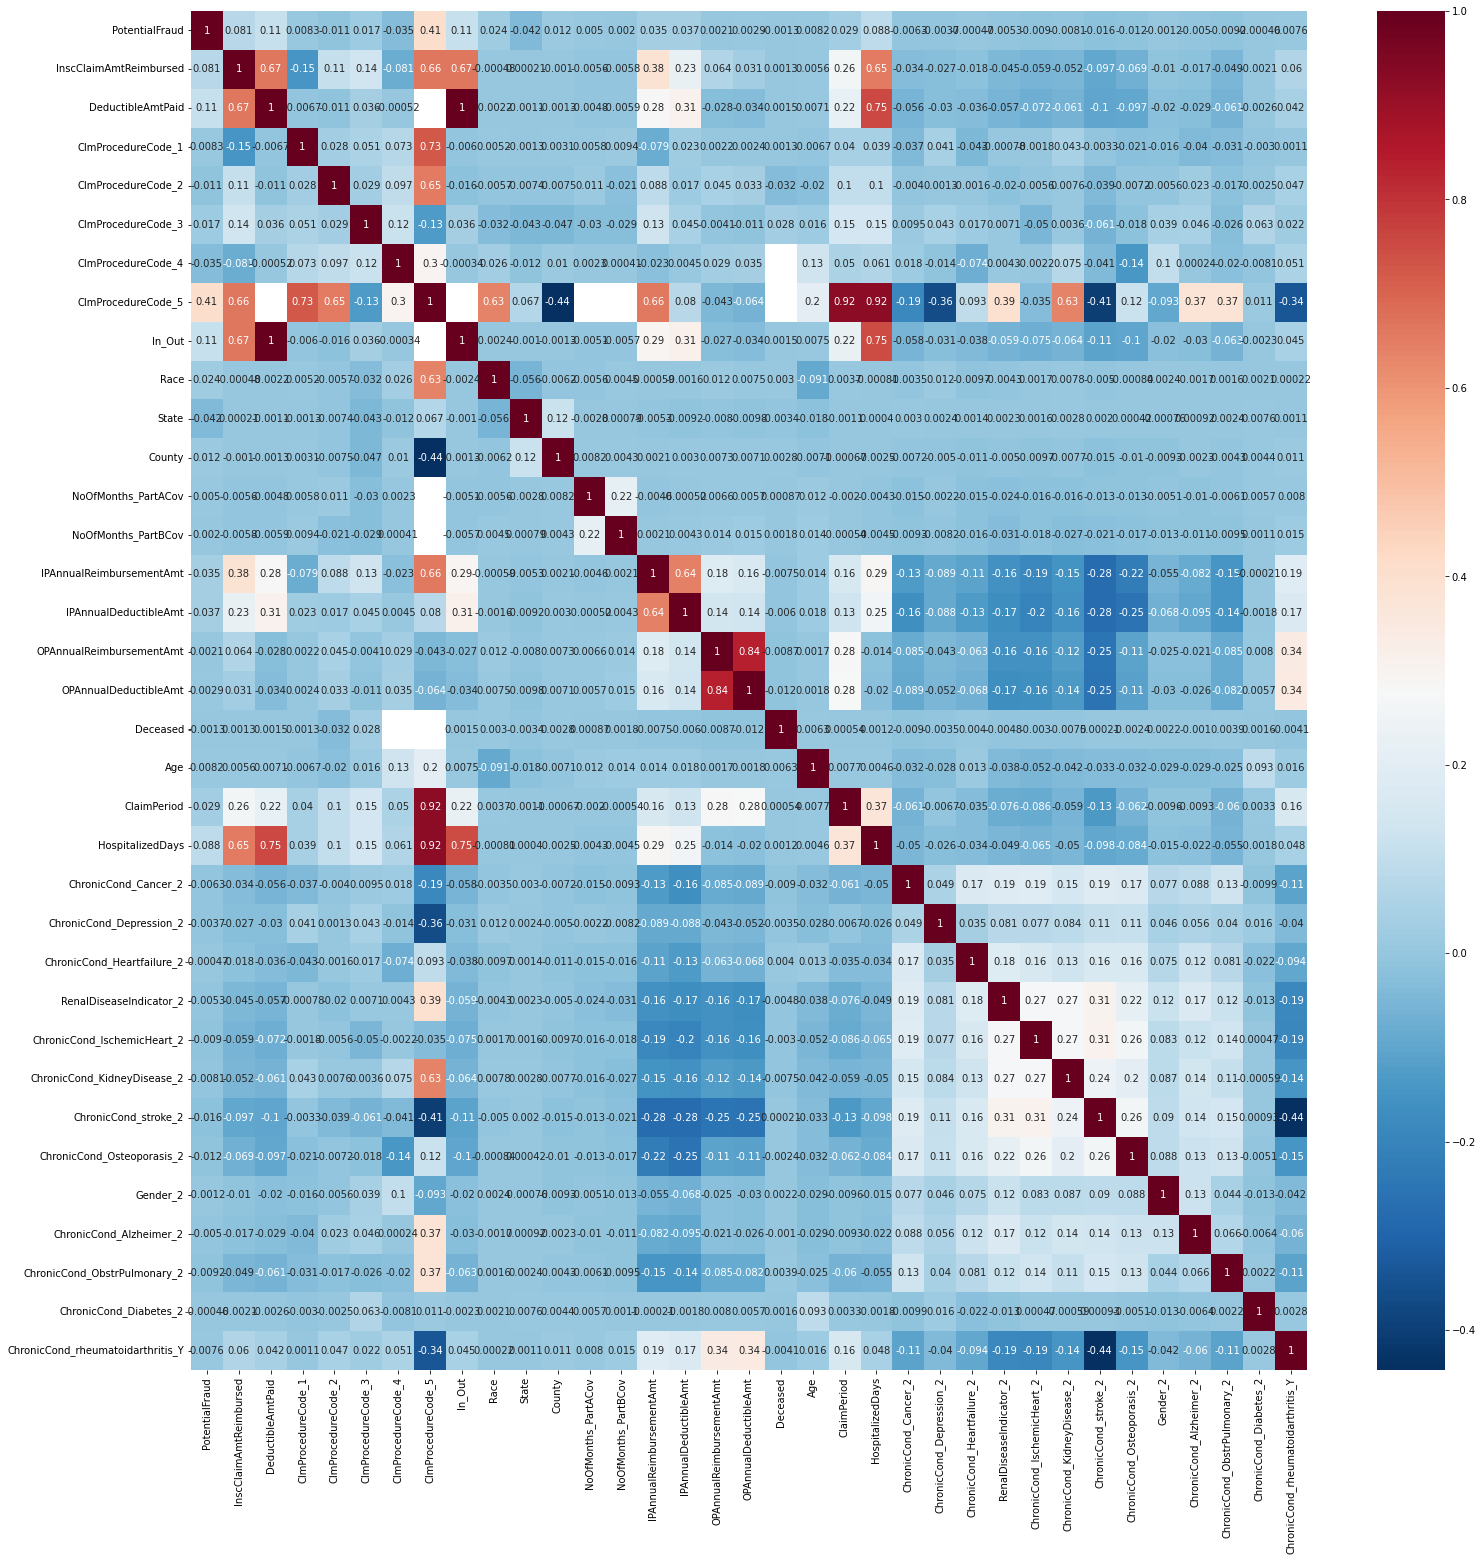

In [17]:
import seaborn as sb

pearsoncorr_num = df_num_reorder.corr(method='pearson')

fig = plt.figure(figsize=(25,25))
sb.heatmap(pearsoncorr_num, 
            xticklabels=pearsoncorr_num.columns,
            yticklabels=pearsoncorr_num.columns,
            cmap='RdBu_r',
            annot=True)

plt.show()

## Train Test Split

In [18]:
test_provider_df = pd.read_csv("output/agg_train_test_split/test_provider_list.csv")
train_provider_df = pd.read_csv("output/agg_train_test_split/train_provider_list.csv")
test_provider_list=test_provider_df['Provider']
train_provider_list=train_provider_df['Provider']

df_train=df_num_reorder[df_num_reorder['Provider'].isin(train_provider_list)].copy()
df_test=df_num_reorder[df_num_reorder['Provider'].isin(test_provider_list)].copy()

df_test.shape,df_train.shape

((115187, 52), (443024, 52))

In [19]:
features=df_num_reorder.columns

y_train=df_train['PotentialFraud'].copy()
y_test=df_test['PotentialFraud'].copy()

X_train=df_train[features[2:]]
X_test=df_test[features[2:]]

In [20]:
# Pipeline

ohe_pipe = Pipeline([('ohetf',OneHotEncoder(handle_unknown='ignore',sparse=False,max_categories=25))])


# Combine the above pipelines
preprocessor = ColumnTransformer([
    #     ''' Dummy and One Hot Encoder'''
    ('ohe',ohe_pipe,cat_dummy_list)
])

## RandomForestClassifier

In [22]:
rf_steps = [('preprocessor',preprocessor),
            ('rescale', StandardScaler()), 
            ('rfc', RandomForestClassifier(n_estimators = 5, random_state = seed1))]
rf_model = Pipeline(rf_steps)
rf_model = rf_model.fit(X_train,y_train) 

In [23]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [24]:
print('Training Accuracy Score: {0:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Testinging Accuracy Score: {0:.3f}'.format(accuracy_score(y_test, y_test_pred)))

Training Accuracy Score: 0.829
Testinging Accuracy Score: 0.470


In [25]:
print('---------------------Train Classification Report--------------------------------\n')
print(classification_report(y_train, y_train_pred))
print('---------------------Test Classification Report--------------------------------\n')
print(classification_report(y_test, y_test_pred))

---------------------Train Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.87      0.84      0.86    269947
           1       0.77      0.81      0.79    173077

    accuracy                           0.83    443024
   macro avg       0.82      0.82      0.82    443024
weighted avg       0.83      0.83      0.83    443024

---------------------Test Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.70      0.34      0.45     75468
           1       0.36      0.72      0.49     39719

    accuracy                           0.47    115187
   macro avg       0.53      0.53      0.47    115187
weighted avg       0.58      0.47      0.46    115187



In [26]:
roc_auc_score_train = roc_auc_score(y_train, rf_model.predict_proba(X_train)[:, 1])  
roc_auc_score_test = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))

roc_auc_score for the train dataset: 0.91
roc_auc_score for the test dataset: 0.54


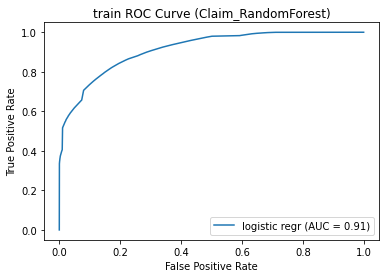

In [27]:
y_train_proba=rf_model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logistic regr')
display.plot()

plt.title('train ROC Curve (Claim_RandomForest)')
plt.show()

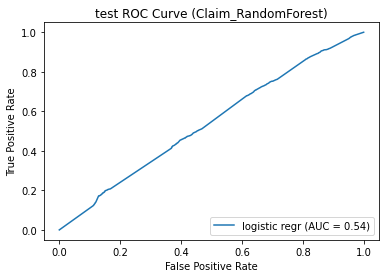

In [28]:
y_test_proba=rf_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logistic regr')
display.plot()

plt.title('test ROC Curve (Claim_RandomForest)')
plt.show()

PR-AUC is 0.89


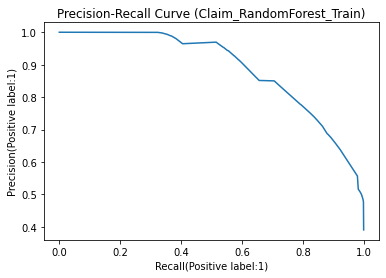

In [29]:
y_score = y_train_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_RandomForest_Train)')
plt.show()

PR-AUC is 0.41


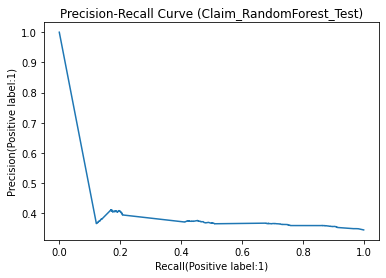

In [30]:
y_score = y_test_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_RandomForest_Test)')
plt.show()

In [31]:
# Aggregate Result to Provider Level and round it to 0/1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3925
         1.0       0.58      0.88      0.70       403

    accuracy                           0.93      4328
   macro avg       0.78      0.91      0.83      4328
weighted avg       0.95      0.93      0.94      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.94      0.28      0.43       979
         1.0       0.11      0.83      0.19       103

    accuracy                           0.33      1082
   macro avg       0.53      0.56      0.31      1082
weighted avg       0.86      0.33      0.41      1082



In [32]:
# Aggregate Result to Provider Level and round it to 0/1
# median

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'median','y_train_pred':'median'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'median','y_test_pred':'median'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3925
         1.0       0.58      0.88      0.70       403

    accuracy                           0.93      4328
   macro avg       0.78      0.91      0.83      4328
weighted avg       0.95      0.93      0.94      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.94      0.28      0.43       979
         1.0       0.11      0.83      0.19       103

    accuracy                           0.33      1082
   macro avg       0.53      0.56      0.31      1082
weighted avg       0.86      0.33      0.41      1082



### Change threshold to be >0.4 as fraud

In [33]:
# Aggregate Result to Provider Level and round it to 0/1

round_threshold=0.1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred+round_threshold)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred+round_threshold)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      3925
         1.0       0.43      0.92      0.59       403

    accuracy                           0.88      4328
   macro avg       0.71      0.90      0.76      4328
weighted avg       0.94      0.88      0.90      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.96      0.23      0.37       979
         1.0       0.11      0.91      0.20       103

    accuracy                           0.30      1082
   macro avg       0.54      0.57      0.29      1082
weighted avg       0.88      0.30      0.36      1082



## XGBClassifier

In [34]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [35]:
xgb_steps = [('preprocessor',preprocessor),
            ('rescale', StandardScaler()),
            ('xgbc', xgb.XGBClassifier(n_estimators = 5,random_state = seed1))]
xgb_model = Pipeline(xgb_steps)
xgb_model = xgb_model.fit(X_train,y_train)

In [36]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [37]:
print('Training Accuracy Score: {0:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Testinging Accuracy Score: {0:.3f}'.format(accuracy_score(y_test, y_test_pred)))

Training Accuracy Score: 0.697
Testinging Accuracy Score: 0.411


In [38]:
print('---------------------Train Classification Report--------------------------------\n')
print(classification_report(y_train, y_train_pred))
print('---------------------Test Classification Report--------------------------------\n')
print(classification_report(y_test, y_test_pred))

---------------------Train Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.68      0.94      0.79    269947
           1       0.77      0.32      0.45    173077

    accuracy                           0.70    443024
   macro avg       0.73      0.63      0.62    443024
weighted avg       0.72      0.70      0.66    443024

---------------------Test Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.83      0.13      0.22     75468
           1       0.36      0.95      0.53     39719

    accuracy                           0.41    115187
   macro avg       0.60      0.54      0.37    115187
weighted avg       0.67      0.41      0.33    115187



In [39]:
roc_auc_score_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1])  
roc_auc_score_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))

roc_auc_score for the train dataset: 0.74
roc_auc_score for the test dataset: 0.54


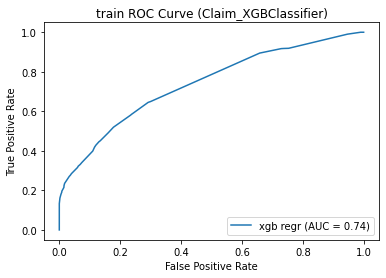

In [40]:
from sklearn.metrics import roc_curve,auc,RocCurveDisplay
y_train_proba=xgb_model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='xgb regr')
display.plot()

plt.title('train ROC Curve (Claim_XGBClassifier)')
plt.show()

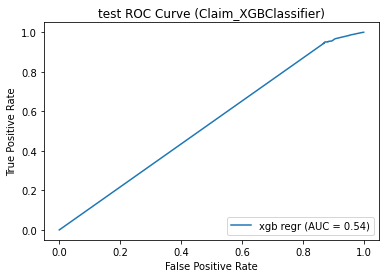

In [41]:
from sklearn.metrics import roc_curve,auc,RocCurveDisplay
y_test_proba=xgb_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='xgb regr')
display.plot()

plt.title('test ROC Curve (Claim_XGBClassifier)')
plt.show()

PR-AUC is 0.69


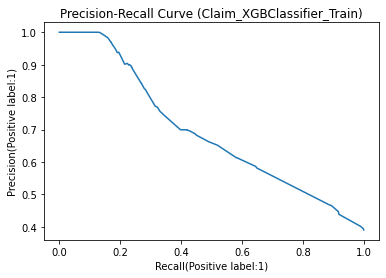

In [42]:
y_score = y_train_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_XGBClassifier_Train)')
plt.show()

PR-AUC is 0.66


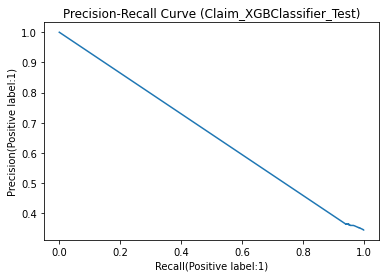

In [43]:
y_score = y_test_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_XGBClassifier_Test)')
plt.show()

In [44]:
# Aggregate Result to Provider Level and round it to 0/1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      3925
         1.0       0.23      0.27      0.25       403

    accuracy                           0.85      4328
   macro avg       0.58      0.59      0.58      4328
weighted avg       0.86      0.85      0.85      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.16      0.27       979
         1.0       0.11      0.98      0.20       103

    accuracy                           0.23      1082
   macro avg       0.55      0.57      0.23      1082
weighted avg       0.90      0.23      0.26      1082



### Change threshold to be >0.4 as fraud

In [45]:
# Aggregate Result to Provider Level and round it to 0/1

round_threshold=0.1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred+round_threshold)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred+round_threshold)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      3925
         1.0       0.25      0.33      0.28       403

    accuracy                           0.84      4328
   macro avg       0.59      0.61      0.60      4328
weighted avg       0.87      0.84      0.85      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.98      0.13      0.23       979
         1.0       0.11      0.98      0.19       103

    accuracy                           0.21      1082
   macro avg       0.55      0.56      0.21      1082
weighted avg       0.90      0.21      0.23      1082



### Change threshold to be >0.3 as fraud

In [46]:
# Aggregate Result to Provider Level and round it to 0/1

round_threshold=0.2

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred+round_threshold)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred+round_threshold)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      3925
         1.0       0.27      0.44      0.33       403

    accuracy                           0.83      4328
   macro avg       0.60      0.66      0.62      4328
weighted avg       0.88      0.83      0.85      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.12      0.21       979
         1.0       0.11      0.99      0.19       103

    accuracy                           0.20      1082
   macro avg       0.55      0.55      0.20      1082
weighted avg       0.91      0.20      0.21      1082



## LogisticRegression

In [47]:
# use StandardScaler and LogisticRegression to build a classification pipeline.

lr_steps = [('preprocessor',preprocessor),
            ('rescale', StandardScaler()),
         ('logr', LogisticRegression(class_weight = 'balanced',random_state=seed1,max_iter=100000))]
lr_model = Pipeline(lr_steps)
lr_model = lr_model.fit(X_train, y_train)

In [48]:
# predacting
# Use the predict function of the model to make predictions for the training set and test set,
# and assign the outputs to y_train_pred and y_test_pred, respectively.

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [49]:
print('Training Accuracy Score: {0:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Testinging Accuracy Score: {0:.3f}'.format(accuracy_score(y_test, y_test_pred)))

Training Accuracy Score: 0.685
Testinging Accuracy Score: 0.393


In [50]:
print('---------------------Train Classification Report--------------------------------\n')
print(classification_report(y_train, y_train_pred))
print('---------------------Test Classification Report--------------------------------\n')
print(classification_report(y_test, y_test_pred))

---------------------Train Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.76      0.70      0.73    269947
           1       0.59      0.66      0.62    173077

    accuracy                           0.68    443024
   macro avg       0.67      0.68      0.68    443024
weighted avg       0.69      0.68      0.69    443024

---------------------Test Classification Report--------------------------------

              precision    recall  f1-score   support

           0       0.86      0.09      0.16     75468
           1       0.36      0.97      0.52     39719

    accuracy                           0.39    115187
   macro avg       0.61      0.53      0.34    115187
weighted avg       0.68      0.39      0.29    115187



logr_importances=lr_model[2].coef_[0]
logr_feature_names=lr_model.feature_names_in_

forest_importances = (pd.Series(logr_importances, index=logr_feature_names))#.sort_values(ascending=True)

fig = plt.figure(figsize=(15,6))
forest_importances.plot.bar()
plt.title("Feature importances (LogisticRegression)")
plt.ylabel("importance")
plt.xlabel("features")
plt.show()

In [51]:
roc_auc_score_train = roc_auc_score(y_train, lr_model.predict_proba(X_train)[:, 1])  
roc_auc_score_test = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
print('roc_auc_score for the train dataset: {:.2f}'.format(roc_auc_score_train))
print('roc_auc_score for the test dataset: {:.2f}'.format(roc_auc_score_test))

roc_auc_score for the train dataset: 0.75
roc_auc_score for the test dataset: 0.59


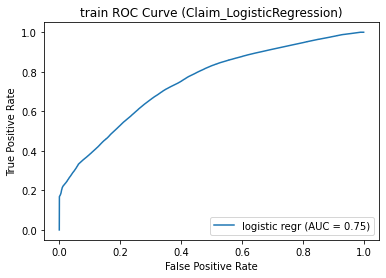

In [52]:
from sklearn.metrics import roc_curve,auc,RocCurveDisplay
y_train_proba=lr_model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logistic regr')
display.plot()

plt.title('train ROC Curve (Claim_LogisticRegression)')
plt.show()

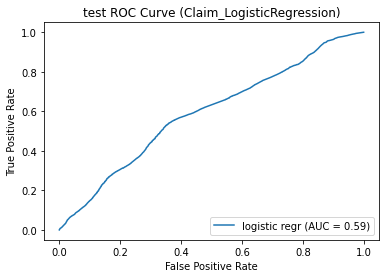

In [53]:
from sklearn.metrics import roc_curve,auc,RocCurveDisplay
y_test_proba=lr_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='logistic regr')
display.plot()

plt.title('test ROC Curve (Claim_LogisticRegression)')
plt.show()

PR-AUC is 0.70


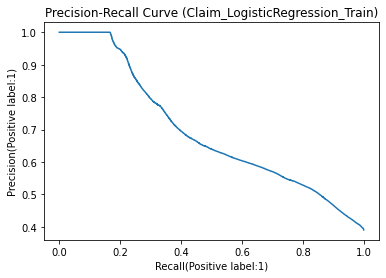

In [54]:
y_score = y_train_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_LogisticRegression_Train)')
plt.show()

PR-AUC is 0.42


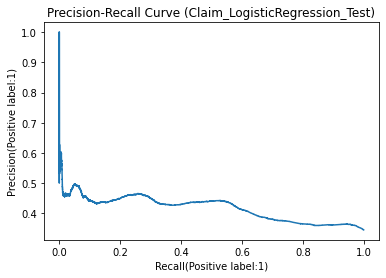

In [55]:
y_score = y_test_proba[:, 1]

# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('PR-AUC is {:.2f}'.format(auc_precision_recall))

# plot PR curve
plt.plot(recall, precision)
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title('Precision-Recall Curve (Claim_LogisticRegression_Test)')
plt.show()

In [56]:
# Aggregate Result to Provider Level and round it to 0/1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      3925
         1.0       0.16      0.54      0.24       403

    accuracy                           0.69      4328
   macro avg       0.55      0.62      0.52      4328
weighted avg       0.86      0.69      0.75      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.11      0.20       979
         1.0       0.10      0.99      0.19       103

    accuracy                           0.19      1082
   macro avg       0.55      0.55      0.19      1082
weighted avg       0.91      0.19      0.20      1082



### Change threshold to be >0.4 as fraud

In [57]:
# Aggregate Result to Provider Level and round it to 0/1

round_threshold=0.1

df_train_comp=df_train[['Provider']].copy()
df_train_comp['y_train']=y_train
df_train_comp['y_train_pred']=y_train_pred

df_train_comp_grouped=df_train_comp.groupby('Provider').agg({'y_train':'mean','y_train_pred':'mean'})
df_train_comp_grouped['y_train_pred_round']=round(df_train_comp_grouped.y_train_pred+round_threshold)

df_test_comp=df_test[['Provider']].copy()
df_test_comp['y_test']=y_test
df_test_comp['y_test_pred']=y_test_pred

df_test_comp_grouped=df_test_comp.groupby('Provider').agg({'y_test':'mean','y_test_pred':'mean'})
df_test_comp_grouped['y_test_pred_round']=round(df_test_comp_grouped.y_test_pred+round_threshold)

print('---------------------Agg Train Classification Report--------------------------------\n')
print(classification_report(df_train_comp_grouped.y_train, df_train_comp_grouped.y_train_pred_round))

print('---------------------Agg Test Classification Report--------------------------------\n')
print(classification_report(df_test_comp_grouped.y_test, df_test_comp_grouped.y_test_pred_round))

---------------------Agg Train Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.95      0.65      0.77      3925
         1.0       0.16      0.64      0.26       403

    accuracy                           0.65      4328
   macro avg       0.55      0.65      0.51      4328
weighted avg       0.87      0.65      0.73      4328

---------------------Agg Test Classification Report--------------------------------

              precision    recall  f1-score   support

         0.0       0.99      0.09      0.17       979
         1.0       0.10      0.99      0.19       103

    accuracy                           0.18      1082
   macro avg       0.55      0.54      0.18      1082
weighted avg       0.91      0.18      0.17      1082



### SVC-not converged